### In this assignment, I have done several tasks below:

*   Visualise the **statistics distribution** of **traffic flows** in Glasgow, UK.

*   Produce an **interactive map** to show the **spatial distribution** of **traffic flows**. When you put the mouse above the point, it gives you the information of ID and the number of daily average traffic flows. 

*   Plot three **static maps** of **land use**, **road network** and **POI** in Glasgow.

*   Generate the **spatial weight matrix** of traffic flows using distance-based method.

*   Calculate the **spatial dependence** of traffic flows using Moran's I test.

*   Model the quantitative relationship between traffic flows and built enviroment (land use, road chatactristics, POI) via linear regression and **spatial error model**.

All the above tasks are implemented via serveral Python libraries and tools, including seaborn, matplotlib, geopandas, pysal, folium and so on. 
 

#### **Notice**:
The data can be downloaded via the link and PIN:

Link: https://gla-my.sharepoint.com/:f:/g/personal/2672496l_student_gla_ac_uk/Ein_sF4g2ThDsy1W205j36IBu02dMWEZZXZk-arkclZkGw?e=axLumG

PIN: Assignment-2023

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd

import pysal
from pysal.viz import mapclassify
from pysal import model
from libpysal.weights import DistanceBand
from esda.moran import Moran

import seaborn as sns
import matplotlib.pyplot as plt
import folium

## 1. Read data

In [3]:
#Set filepath 
traffic_flow = "/data/useful_detector_530_with_flow.shp" 
landcover = '/data/land_cover_osgb36.shp'
road = '/data/20211110_glasgow_road_link.shp'
POI = '/data/2021_06_Glasgow_POI.shp'

# Read file using gpd.read_file() 
traffic_flow = gpd.read_file(traffic_flow)
landcover = gpd.read_file(landcover)
road = gpd.read_file(road)
POI = gpd.read_file(POI)
display(traffic_flow, landcover, road, POI)

siteId     easting    northing   daily_aver    weekly_ave  \
0    GA0151_A  257716.078  665670.358   713.112883   4883.924370   
1    GA0151_C  257988.081  665576.354  2513.927607  17217.235294   
2    GA0151_D  258013.080  665713.356  1526.185276  10452.445378   
3    GA0401_R  258036.081  665650.355   387.815951   2656.050420   
4    GA0401_S  258277.083  665585.351  1839.041718  12595.117647   
..        ...         ...         ...          ...           ...   
525  GL3551_R  254925.063  664457.377  2813.721472  19270.445378   
526  GL3551_S  254866.063  664491.378  1880.642945  12880.033613   
527  GL3551_T  254958.062  664601.378  2261.849080  15490.815126   
528  GL4151_B  253668.044  666113.407   430.333742   2947.243697   
529  GL4151_C  253665.043  666049.406   301.293252   2063.478992   

       monthly_av   daily_Befo   daily_1st_   daily_2nd_   daily_Post  \
0    20040.931035   989.028986   429.815385   475.384615   786.029412   
1    70650.034483  3134.376812  1665.784615  2127.753846  2624.441176   
2    42891.068966  2291.478261   544.784615  1000.630769  1714.911765   
3    10898.965517   606.942029   366.784615   275.861538   332.161765   
4    51683.413793  2985.550725   890.861538  1115.861538  2135.955882   
..            ...          ...          ...          ...          ...   
525  79075.275862  3303.985507  1696.846154  2344.738462  2988.558824   
526  52852.551724  2060.000000  1142.430769  1801.553846  2140.632353   
527  63565.758621  2645.101449  1243.892308  2075.661538  2432.941176   
528  12093.862069   483.202899   378.569231   317.246154   434.588235   
529   8467.379310   314.927536   240.815385   281.107692   310.911765   

                          geometry  
0    POINT (257716.078 665670.358)  
1    POINT (257988.081 665576.354)  
2    POINT (258013.080 665713.356)  
3    POINT (258036.081 665650.355)  
4    POINT (258277.083 665585.351)  
..                             ...  
525  POINT (254925.063 664457.377)  
526  POINT (254866.063 664491.378)  
527  POINT (254958.062 664601.378)  
528  POINT (253668.044 666113.407)  
529  POINT (253665.043 666049.406)  

[530 rows x 11 columns]

fid_ country fua_name fua_code code_2018  \
0        0      UK  Glasgow  UK004L1     11100   
1        0      UK  Glasgow  UK004L1     12100   
2        0      UK  Glasgow  UK004L1     11220   
3        0      UK  Glasgow  UK004L1     12100   
4        0      UK  Glasgow  UK004L1     11210   
...    ...     ...      ...      ...       ...   
7477     0      UK  Glasgow  UK004L1     14100   
7478     0      UK  Glasgow  UK004L1     14100   
7479     0      UK  Glasgow  UK004L1     14100   
7480     0      UK  Glasgow  UK004L1     14100   
7481     0      UK  Glasgow  UK004L1     14200   

                                             class_2018 prod_date  \
0                Continuous urban fabric (S.L. : > 80%)   2020-02   
1     Industrial, commercial, public, military and p...   2020-02   
2     Discontinuous medium density urban fabric (S.L...   2020-02   
3     Industrial, commercial, public, military and p...   2020-02   
4     Discontinuous dense urban fabric (S.L. : 50% -...   2020-02   
...                                                 ...       ...   
7477                                  Green urban areas   2020-02   
7478                                  Green urban areas   2020-02   
7479                                  Green urban areas   2020-02   
7480                                  Green urban areas   2020-02   
7481                      Sports and leisure facilities   2020-02   

         identifier    perimeter           area comment  Pop2018  \
0       247-UK004L1   302.434655    4972.678291    None       29   
1     19971-UK004L1   419.731844    8190.269786    None        3   
2     10880-UK004L1   363.100349    7829.603567    None       40   
3     23162-UK004L1   528.254956   18728.029634    None       21   
4      4154-UK004L1   259.894019    4144.709303    None       24   
...             ...          ...            ...     ...      ...   
7477  25607-UK004L1   450.840285   11651.147435    None        0   
7478  25615-UK004L1   388.022883    3650.883141    None        0   
7479  25645-UK004L1   357.680989    8015.012545    None        0   
7480  25760-UK004L1   444.619427    8679.927820    None        0   
7481  27391-UK004L1  2358.969203  287449.940853    None       23   

                                               geometry  
0     POLYGON ((265843.923 666457.602, 265793.966 66...  
1     POLYGON ((262314.940 663657.545, 262235.603 66...  
2     POLYGON ((252521.199 663457.245, 252504.703 66...  
3     POLYGON ((257970.532 663797.762, 257970.320 66...  
4     POLYGON ((252431.570 663588.138, 252405.849 66...  
...                                                 ...  
7477  POLYGON ((258924.588 667753.573, 258922.325 66...  
7478  POLYGON ((255930.655 667354.559, 255927.743 66...  
7479  POLYGON ((253867.095 668142.608, 253882.970 66...  
7480  POLYGON ((258808.810 667473.148, 258807.230 66...  
7481  POLYGON ((252800.005 669445.207, 252800.199 66...  

[7482 rows x 13 columns]

TOID        identifier identifi_1  beginLifes  \
0      osgb5000005115340622  5000005115340622       None  2018-04-21   
1      osgb4000000005144187  4000000005144187       None  2018-04-21   
2      osgb4000000005263349  4000000005263349       None  2018-04-21   
3      osgb4000000005138143  4000000005138143       None  2018-04-21   
4      osgb5000005154918658  5000005154918658       None  2018-04-21   
...                     ...               ...        ...         ...   
32174  osgb4000000005153181  4000000005153181       None  2018-04-21   
32175  osgb5000005158669118  5000005158669118       None  2018-04-21   
32176  osgb4000000005158273  4000000005158273       None  2018-04-21   
32177  osgb4000000005159399  4000000005159399       None  2018-04-21   
32178  osgb4000000005136739  4000000005136739       None  2018-04-21   

       fictitious validFrom           reasonForC roadClassi  \
0               0      None  Modified Attributes    Unknown   
1               0      None  Modified Attributes    Unknown   
2               0      None  Modified Attributes    Unknown   
3               0      None  Modified Attributes    Unknown   
4               0      None  Modified Attributes    Unknown   
...           ...       ...                  ...        ...   
32174           0      None  Modified Attributes     A Road   
32175           0      None  Modified Attributes    Unknown   
32176           0      None  Modified Attributes     A Road   
32177           0      None  Modified Attributes    Unknown   
32178           0      None  Modified Attributes    Unknown   

                         routeHiera                        formOfWay  ...  \
0                        Local Road               Single Carriageway  ...   
1                        Minor Road               Single Carriageway  ...   
2                        Local Road               Single Carriageway  ...   
3                        Local Road               Single Carriageway  ...   
4                        Minor Road  Traffic Island Link At Junction  ...   
...                             ...                              ...  ...   
32174                        A Road                 Dual Carriageway  ...   
32175  Restricted Local Access Road  Traffic Island Link At Junction  ...   
32176                        A Road                 Dual Carriageway  ...   
32177                    Local Road               Single Carriageway  ...   
32178                    Minor Road                 Dual Carriageway  ...   

       roadStruct  cycleFacil roadWidthM roadWidthA elevationG elevatio_1  \
0            None        None       5.5m       8.5m       1.6m         0m   
1            None        None      11.7m        13m         0m       6.3m   
2            None        None       3.3m       5.9m       0.6m         0m   
3            None        None         6m       6.9m       0.5m         0m   
4            None        None       6.1m      10.1m         0m       0.3m   
...           ...         ...        ...        ...        ...        ...   
32174        None        None      15.2m      15.4m       0.1m         0m   
32175        None        None       3.1m       4.7m         0m       0.6m   
32176        None        None       9.4m      11.1m         0m         2m   
32177        None        None       2.6m       5.3m         0m       4.3m   
32178        None        None       5.9m       8.3m       0.2m       4.4m   

                  startNode               endNode  SHAPE_Leng  \
0      osgb4000000005028998  osgb5000005115340554   33.459691   
1      osgb4000000005018829  osgb4000000005018323  224.066510   
2      osgb4000000005262671  osgb4000000005262672   48.479812   
3      osgb4000000005013311  osgb4000000005013265   69.454440   
4      osgb5000005154917757  osgb5000005154917745   22.016109   
...                     ...                   ...         ...   
32174  osgb4000000005024665  osgb4000000005024631    8.015610   
32175  osgb5000005158666675  os

ref_no                                            name pointx_cla  \
0      159774517                                      Letter Box   06340457   
1      156890041                                        Car Park   10540736   
2       55153703                                           Basin   03580804   
3       55162789                                           Water   03580804   
4       55180162                                     Possil Loch   03580805   
...          ...                                             ...        ...   
28698  163781954                              Crookson Food Bank   06350816   
28699  163781942               Govan Community Project Food Bank   06350816   
28700  163781972                                 AFECC Food Bank   06350816   
28701  163781999  Queen's Park Govanhill Parish Church Food Bank   06350816   
28702  163782066           Glasgow Vineyard Storehouse Food Bank   06350816   

                   groupname                     categoryna  \
0      Public Infrastructure  Infrastructure and Facilities   
1                  Transport                  Road and Rail   
2                Attractions                Bodies Of Water   
3                Attractions                Bodies Of Water   
4                Attractions                Bodies Of Water   
...                      ...                            ...   
28698  Public Infrastructure                  Organisations   
28699  Public Infrastructure                  Organisations   
28700  Public Infrastructure                  Organisations   
28701  Public Infrastructure                  Organisations   
28702  Public Infrastructure                  Organisations   

                      classname  feature_ea  feature_no  pos_accura  \
0                  Letter Boxes    257870.0    659943.4           2   
1                       Parking    260825.0    658697.0           2   
2              Lakes and Waters    259418.0    666662.0           1   
3              Lakes and Waters    258528.0    660573.0           1   
4             Lochs and Lochans    258528.0    670114.0           1   
...                         ...         ...         ...         ...   
28698  Charitable Organisations    252268.0    662483.0           1   
28699  Charitable Organisations    255367.0    665801.0           1   
28700  Charitable Organisations    258387.0    662485.0           1   
28701  Charitable Organisations    257950.0    662517.0           1   
28702  Charitable Organisations    256308.0    666474.0           1   

               uprn  ... postcode    admin_boun   telephone_  \
0              None  ...      G44  Glasgow City         None   
1              None  ...      G45  Glasgow City         None   
2              None  ...       G4  Glasgow City         None   
3              None  ...      G44  Glasgow City         None   
4              None  ...      G23  Glasgow City         None   
...             ...  ...      ...           ...          ...   
28698  906700245062  ...  G53 5TF  Glasgow City   0141882333   
28699  906700170760  ...  G51 3UU  Glasgow City  01414453718   
28700  906700256814  ...  G42 8EJ  Glasgow City  01414332686   
28701  906700430278  ...      G42  Glasgow City  01414233654   
28702  906700511390  ...  G11 6PW  Glasgow City  01413346746   

                                                     url  brand    qualifier_  \
0                                                   None   None          None   
1                                                   None   None          None   
2                                                   None   None  Area in sq m   
3                                                   None   None  Area in sq m   
4                                                   None   None  Area in sq m   
...                                                  ...    ...           ...   
28698                            ccg.scot/projects/1073/   IFAN  Charity Type   
28699  www.govancommunityproject.o

## 2. Statistic distribution of traffic flow

In [4]:
def plotClassification(classi):
    # Set up the figure
    f, ax = plt.subplots(1, figsize=(9, 6))
    # Plot the kernel density estimation (KDE)
    sns.kdeplot(traffic_flow['daily_aver'], shade=True)
    # Add a blue tick for every value at the bottom of the plot (rugs)
    sns.rugplot(traffic_flow['daily_aver'], alpha=0.5)
    # Loop over each break point and plot a vertical red line
    for cut in classi.bins:
        plt.axvline(cut, color='red', linewidth=0.75)
    # Title
    ax.set_title(classi.name)
    # Display image
    plt.show()

In [5]:
classi = mapclassify.Quantiles(traffic_flow['daily_aver'], k=7)
classi

Quantiles

     Interval        Count
--------------------------
[ 129.11,  597.31] |    76
( 597.31,  799.47] |    76
( 799.47,  987.24] |    75
( 987.24, 1192.15] |    76
(1192.15, 1492.00] |    75
(1492.00, 1877.86] |    76
(1877.86, 5170.18] |    76

<ipython-input-4-a123e78f0f64>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic_flow['daily_aver'], shade=True)


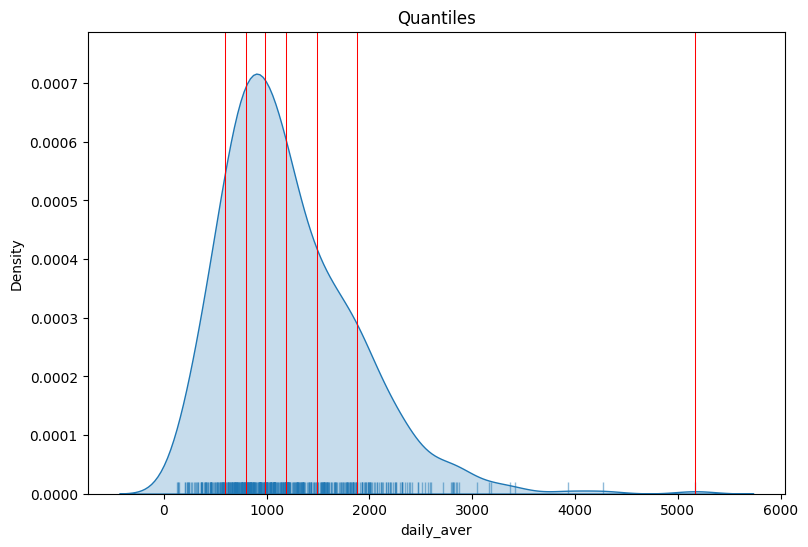

In [6]:
plotClassification(classi)

## 3. Spatial distribution of data

### 3.1 Traffic flow

In [7]:
traffic_flow_map = traffic_flow.explore(column='daily_aver',cmap= 'coolwarm_r',legend=True,tooltip=['siteId','daily_aver'],tiles='cartodbpositron',width=750, height=500)
folium.TileLayer('cartodbdark_matter').add_to(traffic_flow_map)
folium.LayerControl().add_to(traffic_flow_map)

traffic_flow_map

### 3.2 Landcover

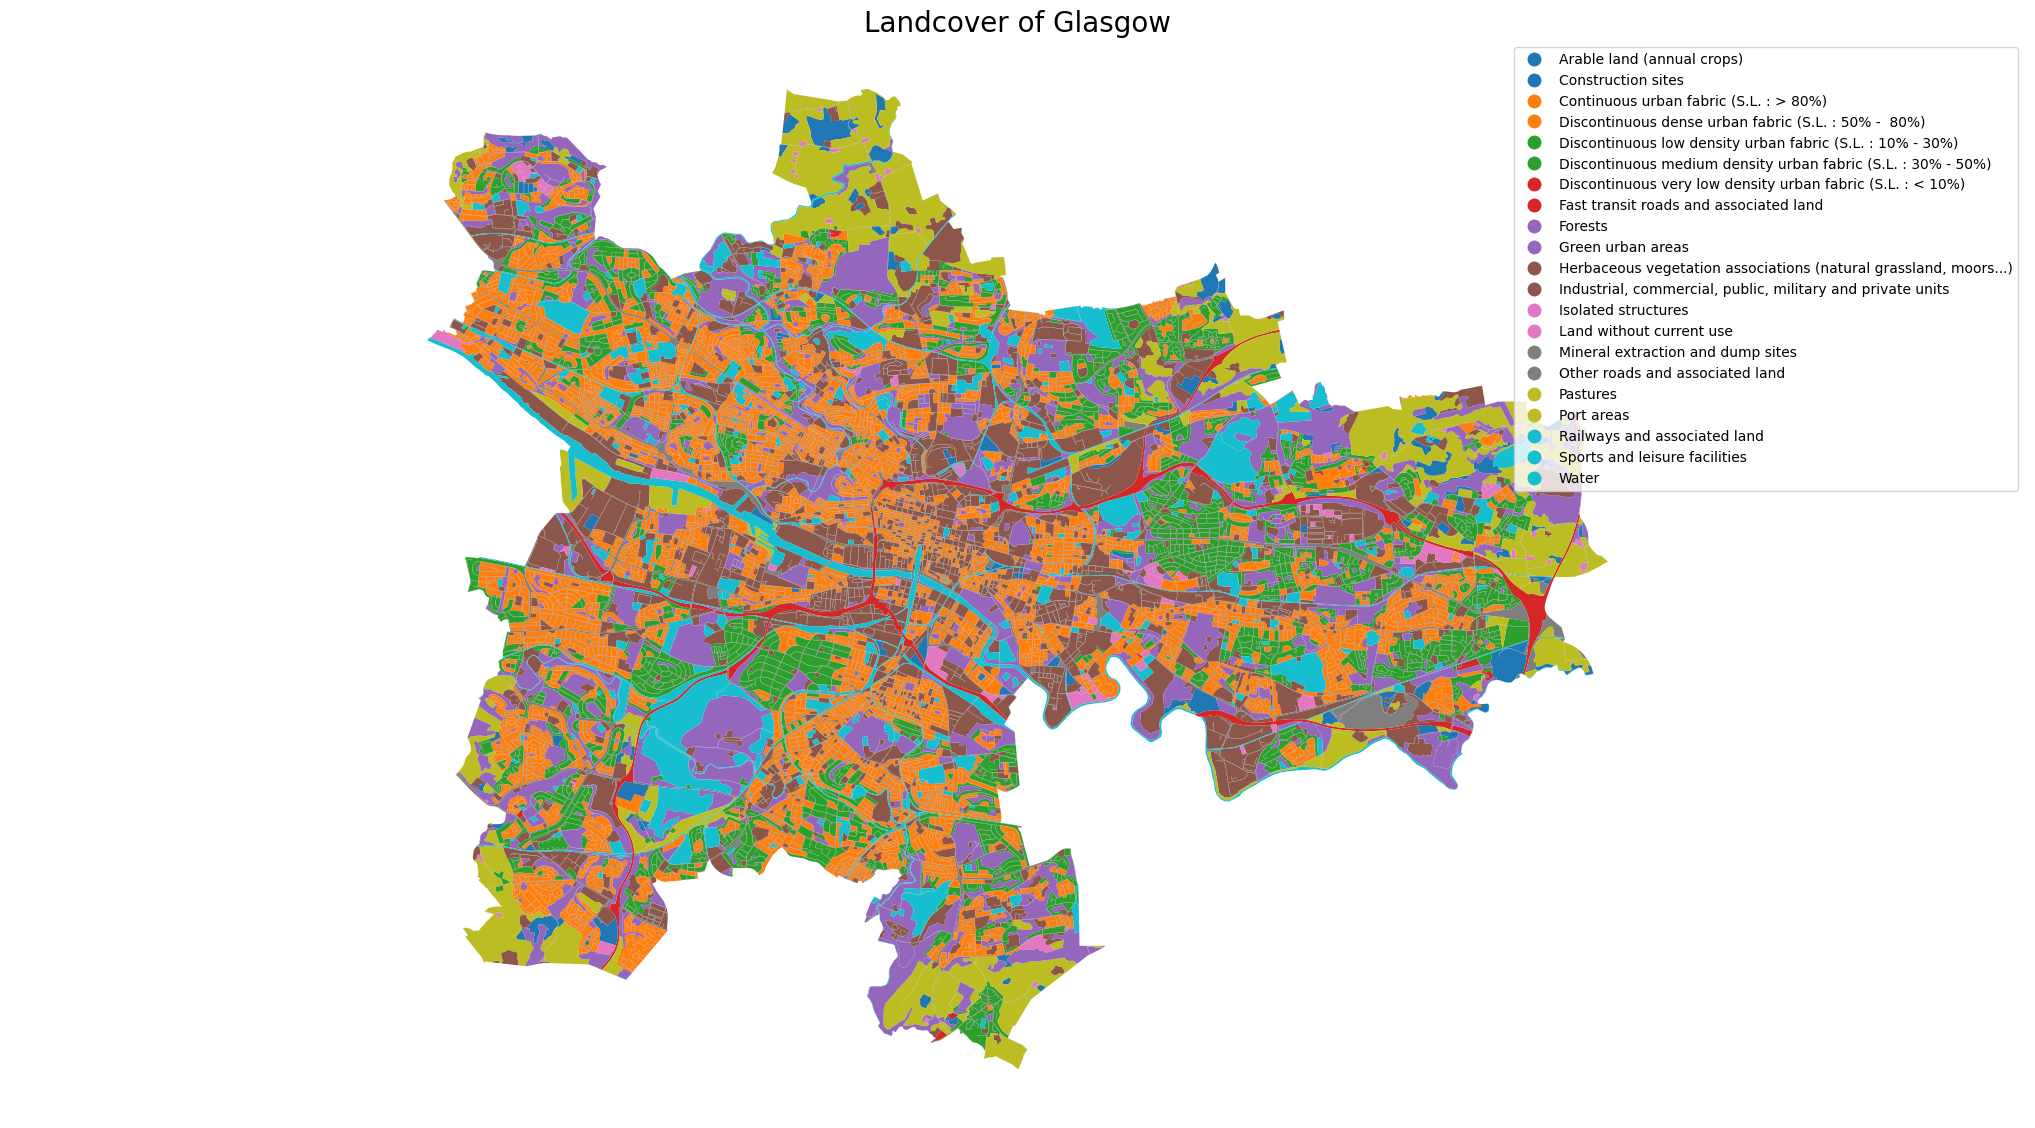

In [8]:
f, ax = plt.subplots(1, figsize=(26, 14))
landcover.plot(column='class_2018', ax=ax, legend=True)
#ctx.add_basemap(ax)
ax.set_axis_off()
plt.axis('equal')
plt.title('Landcover of Glasgow', fontsize=20)
plt.show()

### 3.3 Road Network

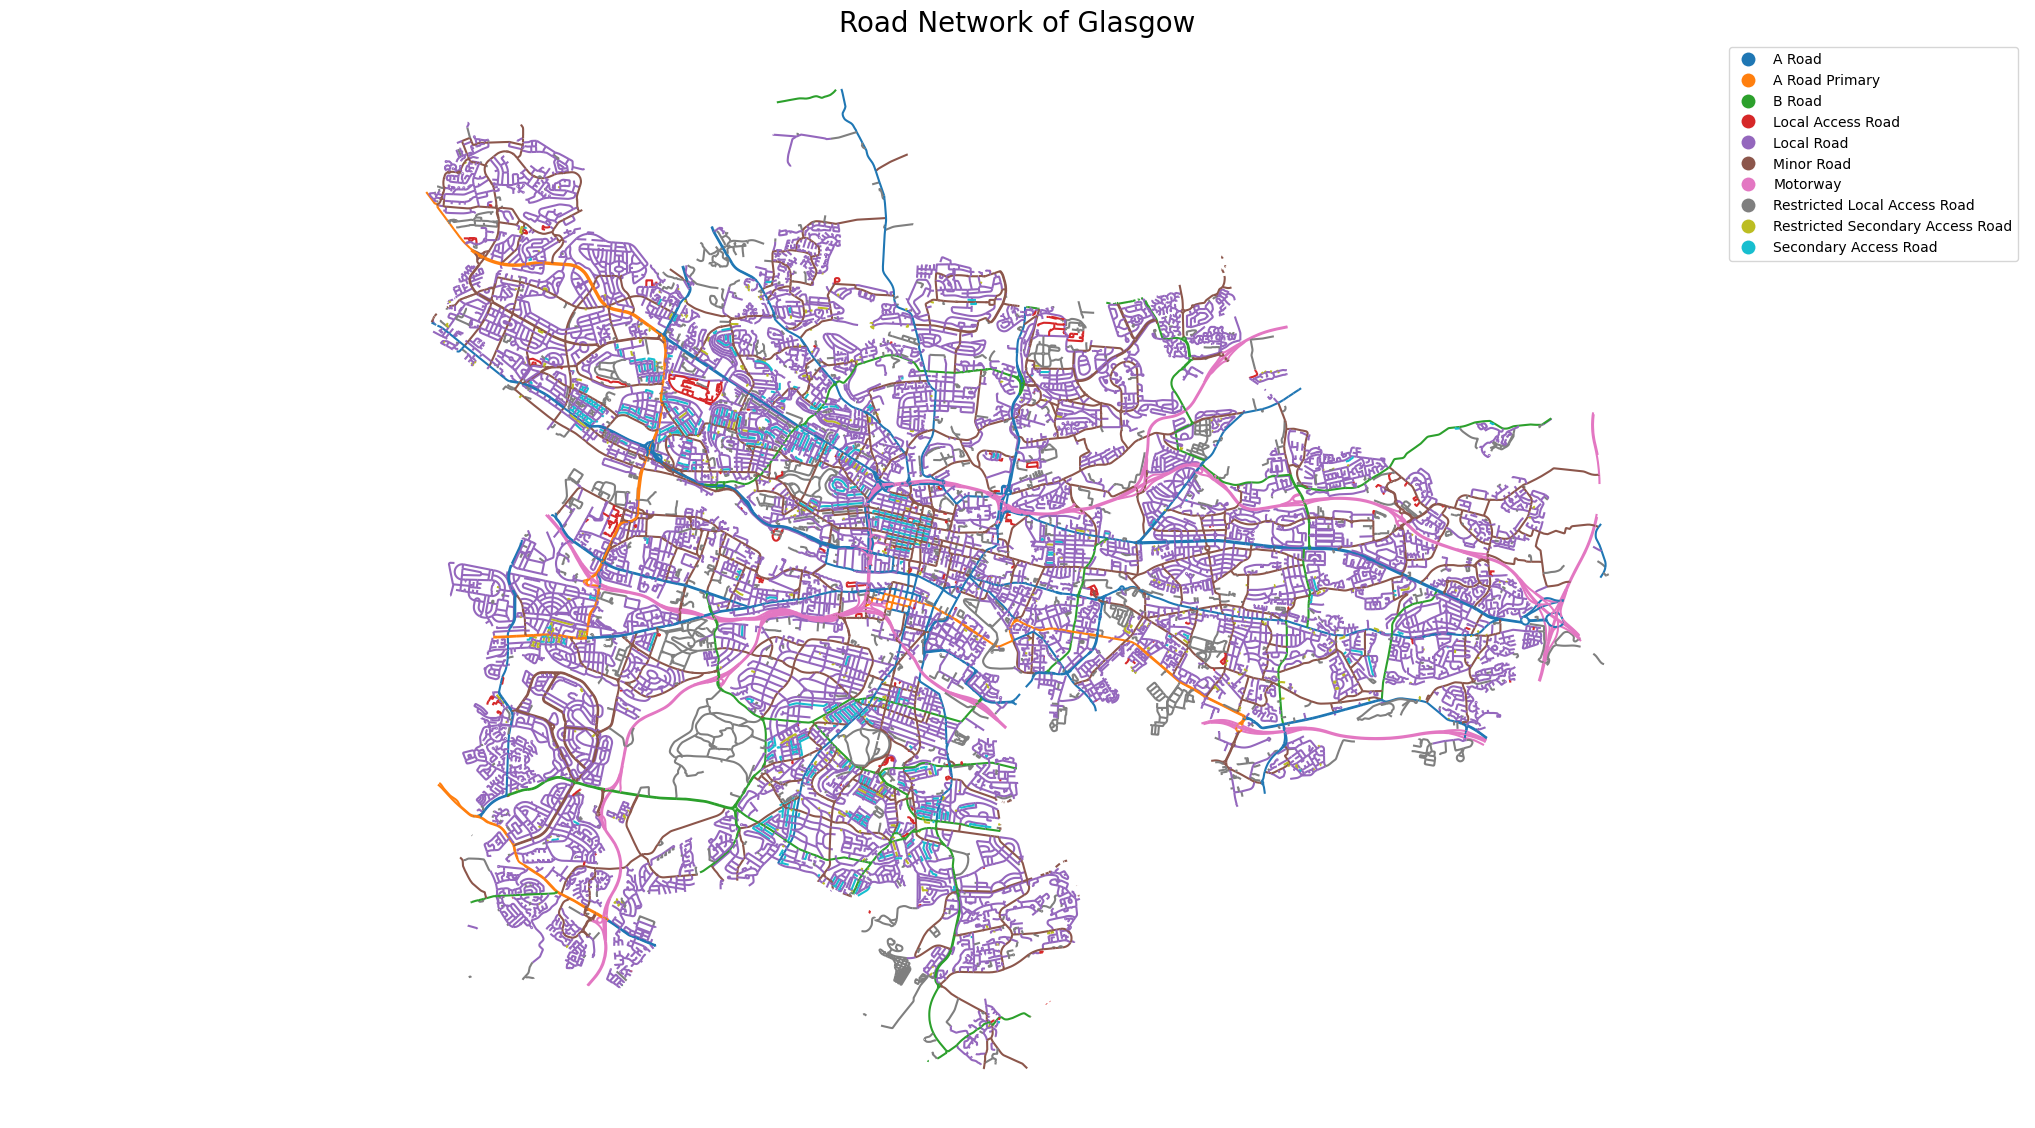

In [9]:
f, ax = plt.subplots(1, figsize=(26, 14))
road.plot(column='routeHiera', ax=ax, legend=True)
#ctx.add_basemap(ax)
ax.set_axis_off()
plt.axis('equal')
plt.title('Road Network of Glasgow', fontsize=20)
plt.show()

### 3.4 POI

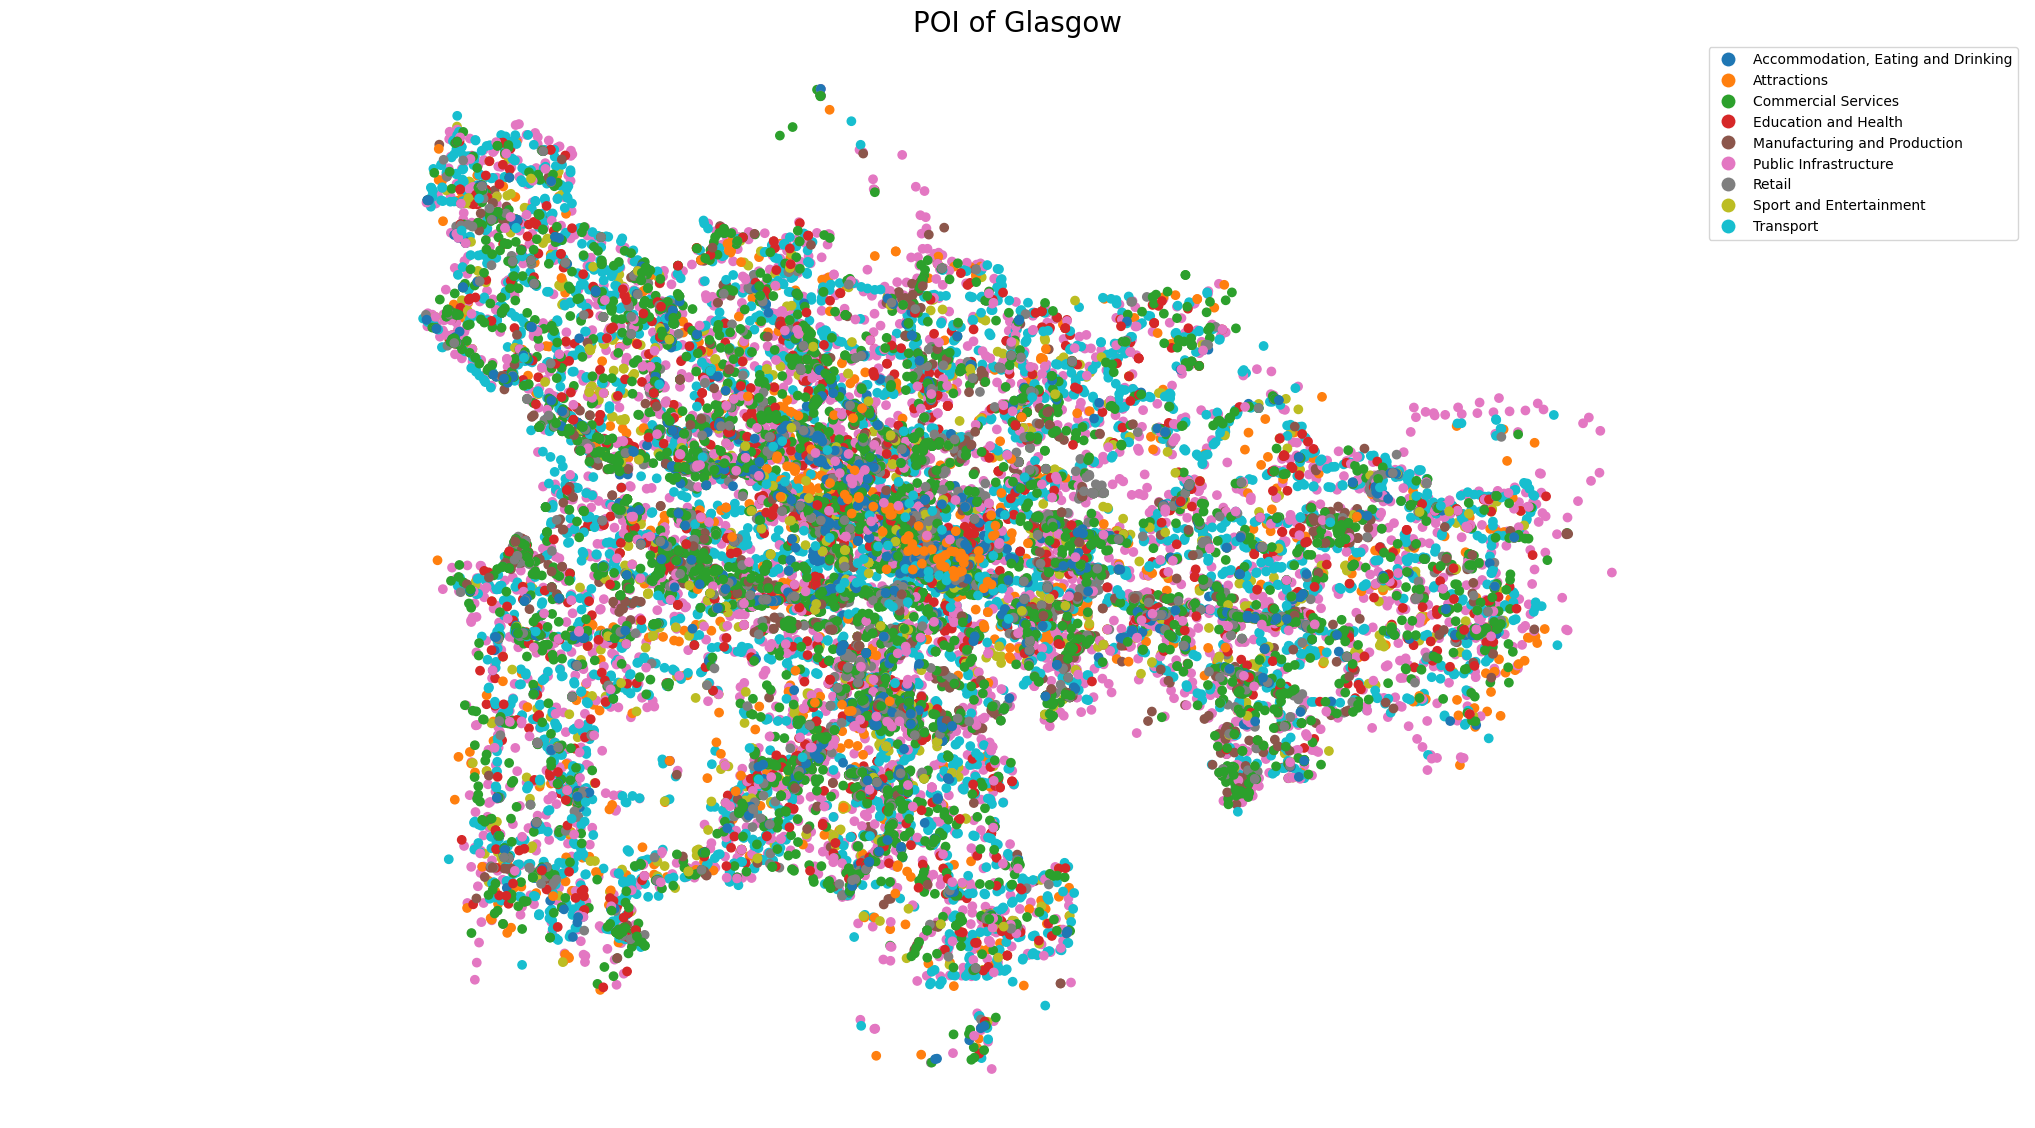

In [10]:
f, ax = plt.subplots(1, figsize=(26, 14))
POI.plot(column='groupname', ax=ax, legend=True)
#ctx.add_basemap(ax)
ax.set_axis_off()
plt.axis('equal')
plt.title('POI of Glasgow', fontsize=20)
plt.show()

## 4. Spatial analysis

### 4.1 Spatial weight matrix

In [11]:
#Distance Based Weights
w = DistanceBand.from_dataframe(traffic_flow, threshold=200, binary=True)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 110 disconnected components.
 There are 32 islands with ids: 57, 116, 128, 133, 135, 227, 228, 237, 248, 252, 254, 260, 264, 265, 269, 397, 405, 415, 428, 435, 436, 451, 460, 478, 485, 486, 487, 488, 489, 490, 507, 523.
  warnings.warn(message)


### 4.2 Spatial correlation

In [12]:
moran = Moran(traffic_flow.daily_aver, w, two_tailed=False)
model_para = pd.DataFrame({'Daily average traffic flows':[moran.I,moran.EI,moran.p_norm,moran.z_norm]},
                          index=['Observed I','Expected I','P-value of I','Z-value of I']).round(decimals=5)
model_para

('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 128, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 227, ' is an island (no neighbors)')
('WARNING: ', 228, ' is an island (no neighbors)')
('WARNING: ', 237, ' is an island (no neighbors)')
('WARNING: ', 248, ' is an island (no neighbors)')
('WARNING: ', 252, ' is an island (no neighbors)')
('WARNING: ', 254, ' is an island (no neighbors)')
('WARNING: ', 260, ' is an island (no neighbors)')
('WARNING: ', 264, ' is an island (no neighbors)')
('WARNING: ', 265, ' is an island (no neighbors)')
('WARNING: ', 269, ' is an island (no neighbors)')
('WARNING: ', 397, ' is an island (no neighbors)')
('WARNING: ', 405, ' is an island (no neighbors)')
('WARNING: ', 415, ' is an island (no neighbors)')
('WARNING: ', 428, ' is an island (no neighbors)')
('WARNING: ', 435, ' is an islan

Daily average traffic flows
Observed I                        0.22550
Expected I                       -0.00189
P-value of I                      0.00000
Z-value of I                      6.12538

### 4.3 Linear regression

In [13]:
# independent variables
inde = pd.read_csv('/data/inde_log_100_new.csv')
# drop variables with VIF>10
x = inde.drop(['employment_density(persons/sq.km)_100','median_age_100'], axis=1)

# dependent variable
y = np.log(traffic_flow.daily_aver)

In [16]:
df_y = np.array(y)
df_x = np.array(x)

ols = pysal.model.spreg.OLS(df_y, df_x, w, spat_diag=True, moran=True,name_x = list(x))
ols_para = pd.DataFrame({'OLS':[ols.lm_error[0],ols.lm_error[1],ols.lm_lag[0],ols.lm_lag[1],
                                                        ols.rlm_error[0],ols.rlm_error[1],ols.rlm_lag[0],ols.rlm_lag[1],
                                                        ols.aic,ols.r2,ols.logll]},
                        index=['LM-Error','P-value of LM-Error', 'LM-Lag','P-value of LM-Lag', 'RLM-Error','P-value of RLM-Error',
                               'RLM-Lag','P-value of RLM-Lag', 'AIC','R-squared','Log-Likelihood'])
display(ols_para)
#print(ols.summary)

OLS
LM-Error               19.885391
P-value of LM-Error     0.000008
LM-Lag                  0.276764
P-value of LM-Lag       0.598830
RLM-Error              22.621269
P-value of RLM-Error    0.000002
RLM-Lag                 3.012642
P-value of RLM-Lag      0.082618
AIC                   893.294992
R-squared               0.151859
Log-Likelihood       -411.647496

### 4.4 Spatial error model


In [17]:
err = pysal.model.spreg.ML_Error(df_y, df_x, w, name_x=list(x))
err_para = pd.DataFrame({'SEM':[err.aic,err.pr2,err.logll]},
                              index=['AIC','Pseudo R-squared','Log-Likelihood'])
display(err_para)
print(err.summary)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


SEM
AIC               869.071847
Pseudo R-squared    0.135501
Log-Likelihood   -399.535923

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         530
Mean dependent var  :      6.9549                Number of Variables   :          35
S.D. dependent var  :      0.5718                Degrees of Freedom    :         495
Pseudo R-squared    :      0.1355
Sigma-square ML     :       0.258                Log likelihood        :    -399.536
S.E of regression   :       0.508                Akaike info criterion :     869.072
                                                 Schwarz criterion     :    1018.623

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------